Text(0.5, 1.0, 'Rayleigh-wave')

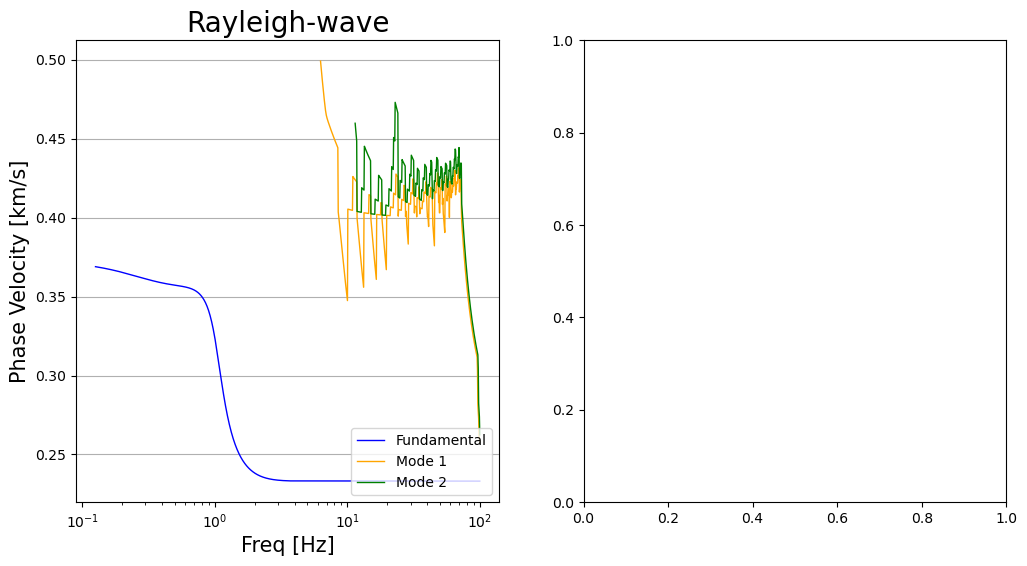

In [9]:
## 计算瑞雷波/勒夫波前三个阶次的相速度频散曲线(根据输入模型计算理论频散曲线)
import numpy as np
from disba import PhaseDispersion           #计算相速度频散
#from disba import GroupDispersion          #计算群速度频散
from disba._helpers import resample 
import matplotlib
from matplotlib import pyplot as plt

# Velocity model
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
velocity_model = np.array([
   [0.1, 0.50, 0.25, 2.00],
   [0.1, 1.00, 0.50, 2.00],
   [0.1, 0.80, 0.40, 2.00]
])

## 0.read velocity model读取速度模型
#velocity_model=np.loadtxt('simple_mod.txt',skiprows=1)
#print('velocity_model=',velocity_model)

## 0.1.对原始速度模型进行重采样
dz = 0.01

velocity_model_thickness=velocity_model.T[0]
velocity_model = resample(velocity_model_thickness.T, velocity_model, dz)
velocity_model = np.array(velocity_model[1])
velocity_model.T[0] = dz


# Periods must be sorted starting with low periods
t = np.logspace(-2, 0.9, 1000)          #创建等比数列(周期)
#t = np.linspace(0.0, 3.0, 100)
# Compute the 3 first Rayleigh- and Love- wave modal dispersion curves 计R/L频散曲线
# Fundamental mode corresponds to mode 0(基阶mode=0)
pd = PhaseDispersion(*velocity_model.T)
#print(pd)
#pd = GroupDispersion(*velocity_model.T)
cpr = [pd(t, mode=i, wave="rayleigh") for i in range(3)]
#cpl = [pd(t, mode=i, wave="love") for i in range(3)]

#print("cpr =",cpr)
#print("mode 0 cpr=",cpr[0])
#print("mode 1 cpr=",cpr[1])
#print("mode 2 cpr =",cpr[2])	
#print("mode 2 cpr period =",cpr[2][0])			#period
#print("mode 2 cpr velocity =",cpr[2][1])		#velocity
#print("mode 2 cpr mode =",cpr[2][2])			#mode
#print("mode 2 cpr wave =",cpr[2][3])			#wave
#print("mode 2 cpr type =",cpr[2].type)			#type
# pd returns a namedtuple (period, velocity, mode, wave, type)


## 开始画图
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6),sharey=False)

## 1.Rayleigh Dispersion
ax1.set_xscale("log")
#ax1.set_xlim(1,1000)
ax1.set_xlabel("Freq [Hz]",fontsize=15)
#ax1.set_ylim(3.2,4.8)
ax1.grid(axis="y")
ax1.set_ylabel("Phase Velocity [km/s]",fontsize=15)
ax1.plot(1./cpr[0][0], cpr[0][1], color="blue", linewidth=1, label="Fundamental")
ax1.plot(1./cpr[1][0], cpr[1][1], color="orange", linewidth=1, label="Mode 1")
ax1.plot(1./cpr[2][0], cpr[2][1], color="green", linewidth=1, label="Mode 2")
ax1.legend(loc="lower right", fontsize=10)
ax1.set_title("Rayleigh-wave", fontsize=20)



In [17]:
freq = 1./cpr[0][0]; velo = cpr[0][1]; preiod = cpr[0][0]

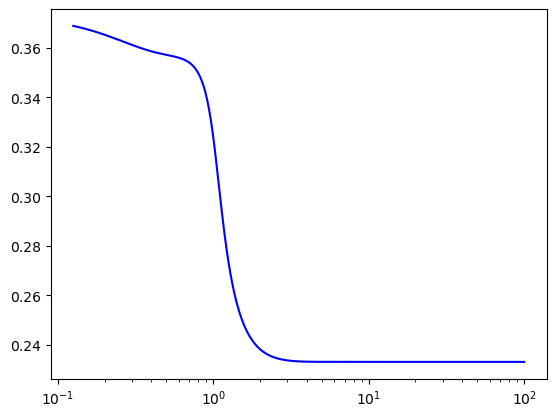

In [16]:
plt.xscale("log")
plt.plot(freq,velo,'b-',label='Rayleigh-wave')

In [ ]:
np.savetxt('period_velo.txt',np.c_[preiod,velo],delimiter=' ',header='period,velo')

In [1]:
import torch
import torch.nn as nn

from hvsrUNet.module.model import UNet
from hvsrUNet.module.trainer import train
from hvsrUNet.module.dataset import MkData
from hvsrUNet.toolbox.plot import plotTest, plotLoss, plotHVSR, plotModel
from hvsrUNet.toolbox.hvsrIO import saveModel, loadModel

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(1, 2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.linear = nn.Linear(1000, 5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        return self.softmax(x)
    


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


In [21]:
model = nn.Sequential(
    UNet(1, 1)
    )
yy = model(X)
yy.shape

torch.Size([32, 1, 1, 5])

In [ ]:
from typing import Any
from sklearn.model_selection import train_test_split
import torch
  
class MkData():
    """
    Make the dataset.
    """
    def __init__(self):
        # self.sampleNum = sampleNum
        # self.layerNum = layerNum
        # self.num_h1 = num_h1
        # self.num_h2 = num_h2
        # self.dx = dx
        # self.depth_end = depth_end
        # self.freqs_end = freqs_end
        # self.HVSR = torch.zeros((4, 8, 2, self.num_h1, self.num_h2, self.sampleNum))
        # self.VVs = torch.zeros((4, 8, 2, self.num_h1, self.num_h2, self.sampleNum))
        pass

    def __call__(self, sampleNum=512, layerNum=3, num_h1=20, num_h2=20, dx=0.8, depth_end=200., freqs_end=50):
        self.sampleNum = sampleNum
        self.layerNum = layerNum
        self.num_h1 = num_h1
        self.num_h2 = num_h2
        self.dx = dx
        self.depth_end = depth_end
        self.freqs_end = freqs_end
        self.HVSR = torch.zeros((4, 8, 2, self.num_h1, self.num_h2, self.sampleNum))
        self.VVs = torch.zeros((4, 8, 2, self.num_h1, self.num_h2, self.sampleNum))

        train_iter, test_iter = self.getIter()

        return train_iter, test_iter


    def set_array(self, thickness, velocity, depth_max):
        """
        Set the x and y coordinates of the model layers.

        Args:
            thickness (list): List of layer thicknesses.
            velocity (list): List of layer velocities.
            depth_max (float): Maximum depth.

        Returns:
            x (list): List of x-coordinates.
            y (list): List of y-coordinates.
        """
        if len(thickness) < len(velocity):
            thickness.append(0)
        
        j = 1
        x = [velocity[0]]
        y = [0]
        
        j += 1
        x.append(velocity[0])
        y.append(thickness[0])
        
        for i in range(1, len(velocity)):
            j += 1
            x.append(velocity[i])
            y.append(y[j-2])
            
            j += 1
            x.append(velocity[i])
            y.append(y[j-2] + thickness[i])
        
        y[-1] = depth_max
        
        return x, y



    def calc_hvsr(self, vel, thi, den, damp, freq):
        """
        Calculate the horizontal-to-vertical spectral ratio (HVSR).

        Args:
            vel (list): List of shear wave velocities of layers.
            thi (list): List of thicknesses of layers.
            den (list): List of densities of layers.
            damp (list): List of damping ratios of layers.
            freq (list): List of frequencies.

        Returns:
            hvsr (list): List of HVSR values.
        """
        a = torch.ones(len(freq))
        b = torch.ones(len(freq))
        
        for jm in range(len(vel)-1):
            a1 = den[jm]
            a2 = den[jm+1]
            alfa = (a1*vel[jm]*(1+1j*damp[jm])) / (a2*vel[jm+1]*(1+1j*damp[jm+1]))
            ksH = 2 * torch.pi * freq * thi[jm] / (vel[jm] + damp[jm]*1j*vel[jm])
            A = 0.5 * a * (1 + alfa) * torch.exp(1j*ksH) + 0.5 * b * (1 - alfa) * torch.exp(-1j*ksH)
            B = 0.5 * a * (1 - alfa) * torch.exp(1j*ksH) + 0.5 * b * (1 + alfa) * torch.exp(-1j*ksH)
            
            a = A
            b = B
        
        hvsr = torch.abs(1 / A)
        
        return hvsr

    def den(self, Vs):
        Den = torch.zeros(len(Vs))
        for i, vs in enumerate(Vs):
            Den[i] = 0.85 * vs**0.14
        return Den

    def damp(self, Vs):
        Damp = torch.zeros(len(Vs))
        for i, vs in enumerate(Vs):
            if vs < 1000:
                Damp[i] = 1/(2 * 0.06 * vs)
            elif vs < 2000:
                Damp[i] = 1/(2 * 0.04 * vs)   
            else:
                Damp[i] = 1/(2 * 0.16 * vs)
        return Damp

    def getHVSR(self, v1, v2, v3, num_h1, num_h2, dx, depth_end, sampleNum, HVSR, VVs, freqs_end):
        for h1 in range(0, num_h1,):
            for h2 in range(0, num_h2,):
                H1 = h1 * dx + 1
                H2 = h2 * dx + 1
                H3 = depth_end - H1 - H2
                H = [H1, H2, H3]
                Vs = [v1, v2, v3]
                Den = self.den(Vs)
                Damp = self.damp(Vs)

                depthmax = sum(H) + sum(H)*10./100

                #model_x, model_y = self.set_array(H, Vs, depthmax)

                freqs = torch.linspace(0, freqs_end, sampleNum)
                ## main function to get HVSR
                HVSR[int((v1-200)/50)][int((v2-400)/50)][int((v3-600)/50)][h1][h2] = self.calc_hvsr(Vs, H, Den, Damp, freqs)

                VVs[int((v1-200)/50)][int((v2-400)/50)][int((v3-600)/50)][h1][h2][0:h1*5] =  Vs[0]
                VVs[int((v1-200)/50)][int((v2-400)/50)][int((v3-600)/50)][h1][h2][h1*5:(h1+h2)*5] =  Vs[1]
                VVs[int((v1-200)/50)][int((v2-400)/50)][int((v3-600)/50)][h1][h2][(h1+h2)*5:] =  Vs[2]

        return HVSR, VVs

    def getIter(self):
        num_h1 = self.num_h1
        num_h2 = self.num_h2
        sampleNum = self.sampleNum
        dx = self.dx
        depth_end = self.depth_end
        HVSR = self.HVSR
        VVs = self.VVs
        freqs_end = self.freqs_end

        for v1 in range(200, 400, 50):
            for v2 in range(400, 800, 50):
                for v3 in range(600, 700, 50):
                    HVSR, VVs = self.getHVSR(v1, v2, v3, num_h1, num_h2, dx, depth_end, sampleNum, HVSR, VVs, freqs_end)

                    

        VVs = VVs.reshape(-1, sampleNum); HVSR = HVSR.reshape(-1, sampleNum)
        VVs = VVs.reshape(-1, 1, 1, sampleNum); HVSR = HVSR.reshape(-1, 1, 1, sampleNum)

        # 将HVSR制成训练集， VVs制成标签
        VVs = VVs / 100.

        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(HVSR, VVs, test_size=0.3, random_state=42)
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)  
        test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

        return train_iter, test_iter